# what are the features influencing students successfully finish ND 2

## after the feature selection 1 in general, I found that there's some correlated patterns show up between user_age and cohort_open_to_notify, cohort_open_to_close, apply_before_start, apply_to_update, apply_to_submit, submit_to_decision; 3 timestamps in a cohort (from open, close, to notify)
## want to do a clustering on these features. also take into account of num_of_courses taken/finished/enrolled

## add payment first attempt day as a new feature
## add engagement as a new feature: freq. visit classroom, project start time, project submission status, etc..

## import data

In [1]:
import psycopg2
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import random
import re
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
conn_laurel = psycopg2.connect("dbname='analytics' user='analytics' host='analytics.cv90snkxh2gd.us-west-2.rds.amazonaws.com' password='!TgP$Ol9Z&6QhKW0tmn9mOW5rYT2J8'")
conn_hardy = psycopg2.connect("dbname='analytics' user='u_yidong' host='udacity-segment.c2zpsqalam7o.us-west-2.redshift.amazonaws.com' port='5439' password='Lyd580809?!'")

sql_apps = "SELECT distinct a.id as application_id,a.cohort_id,a.applicant_id,a.nd_key,a.application_type\
      ,coalesce(a.applicant_country,'Unknown') as applicant_country\
      ,coalesce(a.applicant_geo,'Unknown') as applicant_geo\
      ,case when b.user_id is not null then 'term completed'\
            when a.first_charge_created_at is not null and a.accepted_at is not null then 'paid'\
            when a.accepted_at is not null then 'accepted'\
            when a.rejected_at is not null then 'rejected'\
            when a.submitted_at is not null then 'submitted'\
       else 'applied' end as application_status\
      ,current_date - a.applicant_created_at::date as user_age\
      ,a.cohort_notify_at::date - a.cohort_open_at::date as cohort_open_to_notify\
      ,a.cohort_close_at::date - a.cohort_open_at::date as cohort_open_to_close\
      ,date_part('month',a.cohort_open_at) as cohort_open_month\
      ,date_part('month',a.application_created_at) as application_month\
      ,a.application_created_at::date - a.cohort_open_at::date as apply_before_start\
      ,a.submitted_at::date - a.application_created_at::date as apply_to_submit\
      ,coalesce(a.accepted_at,a.rejected_at)::date - a.submitted_at::date as submit_to_decision\
      ,a.cohort_notify_at::date - a.submitted_at::date as submit_to_notify\
      ,greatest(coalesce(c.first_charge_attempt::date,a.first_charge_created_at::date) - a.cohort_notify_at::date,0) as notify_to_pay\
      ,coalesce(a.price,0)::int as price\
       FROM admissions.applications as a\
       LEFT JOIN enrollments.term_completions as b ON a.applicant_id = b.user_id and a.nd_key = b.nd_key\
       LEFT JOIN (select distinct account_key,nd_key,cohort_id,min(charge_created_at) as first_charge_attempt from payments.charges\
                  group by account_key,nd_key,cohort_id) as c on a.applicant_id = c.account_key and substring(a.nd_key,0,6) = substring(c.nd_key,0,6) \
            and (case when a.application_type = 'term' then a.cohort_id::int else 0 end) = coalesce(c.cohort_id,0)\
       WHERE accepted_at is not null and first_charge_created_at is not null\
         AND email not like '%@udacity%';"
sql_course = "select application_id,cohort_id,user_id AS applicant_id,nanodegree_key AS nd_key\
       ,count(distinct course_key) as num_courses\
       ,count(distinct case when course_finished = 2 then course_key else null end) as num_course_finished\
       ,count(distinct case when course_finished = 1 then course_key else null end) as num_course_enrolled\
       ,current_date - first_course_started_at::date AS user_study_age\
 from (select distinct b.application_id,b.cohort_id,a.user_id,b.nanodegree_key,course_key,join_time,leave_time\
             ,first_value(join_time) over (partition by a.user_id order by join_time rows between unbounded preceding and unbounded following) as first_course_started_at\
             ,case when a.leave_time::Date <= b.received_at::Date then 2\
                   when a.leave_time is not null then 1 \
              else 0 end as course_finished\
       from analytics_tables.course_enrollments as a\
       inner join backend_admissions.application_received as b on a.user_id = b.user_id\
       where a.join_time <= b.received_at\
      ) group by application_id,cohort_id,user_id,nanodegree_key,current_date - first_course_started_at::date"

df_apps = pd.read_sql(sql_apps,conn_laurel)
df_course = pd.read_sql(sql_course,conn_hardy)

df = pd.merge(df_apps,df_course,on=['application_id','cohort_id','applicant_id','nd_key'],how='inner')

In [3]:
df.shape

(4381, 23)

In [4]:
df.groupby(['application_status'])['application_id'].count()

application_status
paid              3733
term completed     648
Name: application_id, dtype: int64

# user_age + cohort info:

## user_age + cohort_open_to_notify : sig.
- in general, longer user age, higher grad. Rate
- if user age < 3 months, shorter time to notify, higher grad. rate

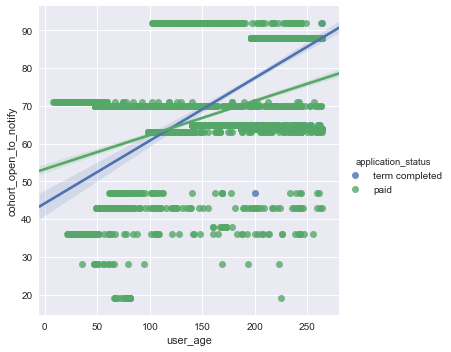

In [5]:
sns.lmplot(x="user_age", y="cohort_open_to_notify", data=df, hue='application_status')

## User_age + cohort_open_to_close (app length) : not sig.

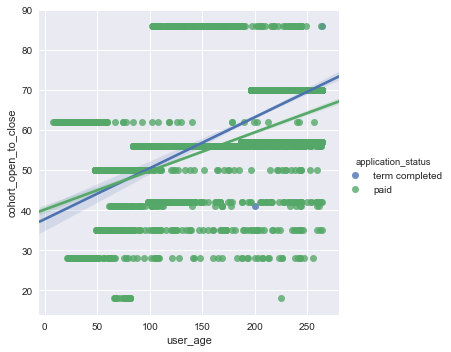

In [6]:
sns.lmplot(x="user_age", y="cohort_open_to_close", data=df, hue='application_status')

# user_age + user_based_data

## User_age + apply_before_start (days before cohort start): sig.
- in general, longer user age, higher grad. Rate
- suspect: there’s some connect data here influencing the result  

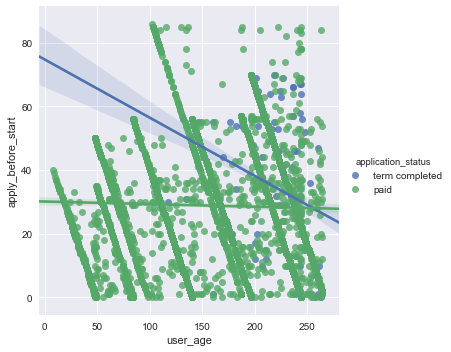

In [7]:
sns.lmplot(x="user_age", y="apply_before_start", data=df, hue='application_status')

## User_age +  apply_to_submit: sig.
- Shorter time to submit, higher grad. Rate
- long user_age + short_time_to_submit: very good combination

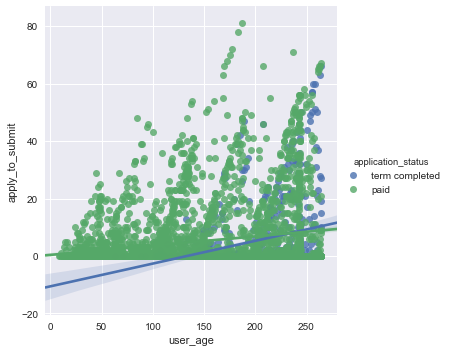

In [8]:
sns.lmplot(x="user_age", y="apply_to_submit", data=df, hue='application_status')

## User_age + submit_to_decision (accept/reject: ?internal decision): not sig. 

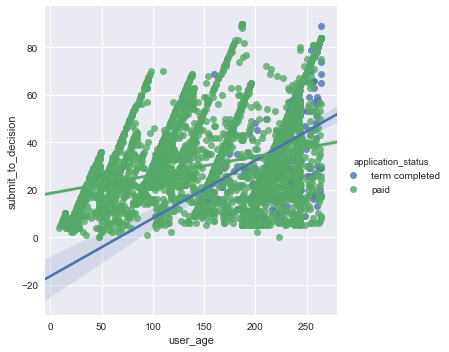

In [9]:
sns.lmplot(x="user_age", y="submit_to_decision", data=df, hue='application_status')

## User_aget + submit_to_notify: not sig.

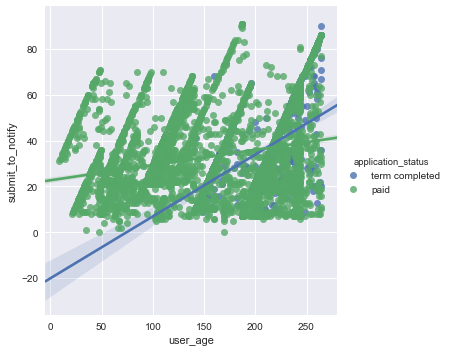

In [10]:
sns.lmplot(x="user_age", y="submit_to_notify", data=df, hue='application_status')

## User_age + notify_to_pay: sig.
- less time taken to put down payment, higher grad. Rate
- long user_age + short_time_to_pay: very good combination

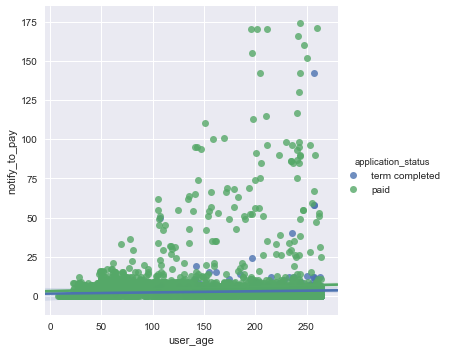

In [11]:
sns.lmplot(x="user_age", y="notify_to_pay", data=df, hue='application_status')

# user_based_data by itself

## Apply_before_start, apply_to_submit, notify_to_pay:

* Apply_before_start: would be great if we can see the time between a student aware of this course and start to apply. Without this info, I just use days before cohort starts to get some ideas
* Apply_to_submit: how quickly to submit
* Notify_to_pay: how quickly to pay

* Result: not very sig. in all. But a pattern shows shorter time taken to apply before start, shorter time to submit and shorter time to pay has better grad. rate.

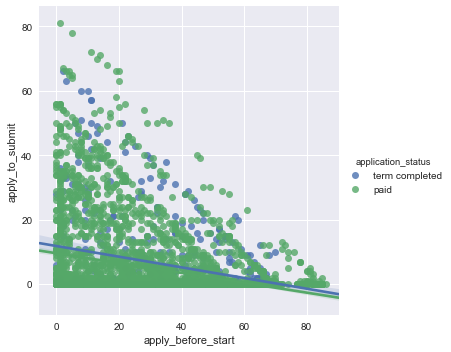

In [12]:
sns.lmplot(x="apply_before_start", y="apply_to_submit", data=df, hue='application_status')

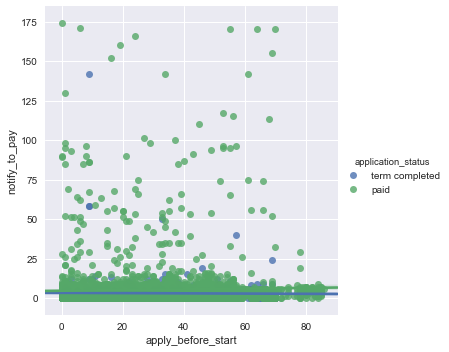

In [13]:
sns.lmplot(x="apply_before_start", y="notify_to_pay", data=df, hue='application_status')

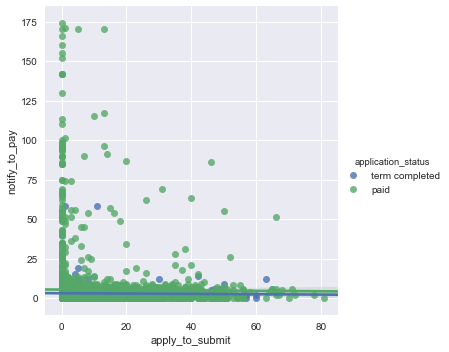

In [14]:
sns.lmplot(x="apply_to_submit", y="notify_to_pay", data=df, hue='application_status')

# cohort data by itself

## Cohort_open_to_close + cohort_open_to_notify: sig. 
- if apps length < 60 days (2 months), then less time taken to notify, higher grad. Rate
- if apps length > 60 days (2 months), then doesn’t matter

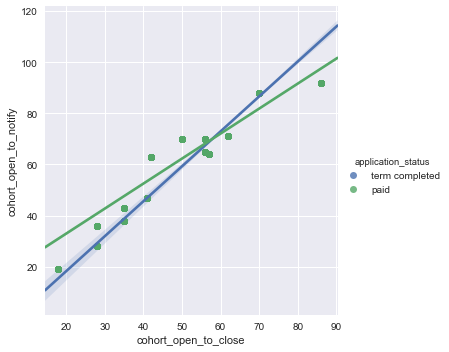

In [15]:
sns.lmplot(x="cohort_open_to_close", y="cohort_open_to_notify", data=df, hue='application_status')

# Summary:

* in general, longer user age, higher grad. Rate
* if user age < 3 months, shorter time to notify, higher grad. rate
* Shorter time to submit, higher grad. Rate
* long user_age + short_time_to_submit: very good combination
* less time taken to put down payment, higher grad. Rate
* long user_age + short_time_to_pay: very good combination

* a pattern shows shorter time taken to apply before start, shorter time to submit and shorter time to pay has better grad. rate

* if cohort apps length (cohort close - open) < 60 days (2 months), then less time taken to notify, higher grad. Rate
* if cohort apps length > 60 days (2 months), then doesn’t matter


* suspect: there’s some connect data here influencing the result 

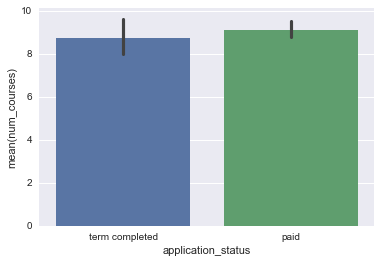

In [16]:
sns.barplot(x="application_status", y="num_courses", data=df)

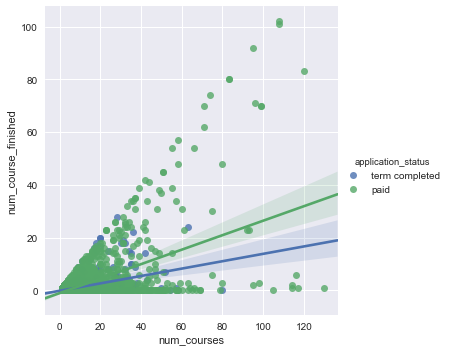

In [17]:
sns.lmplot(x="num_courses", y="num_course_finished", data=df, hue='application_status')

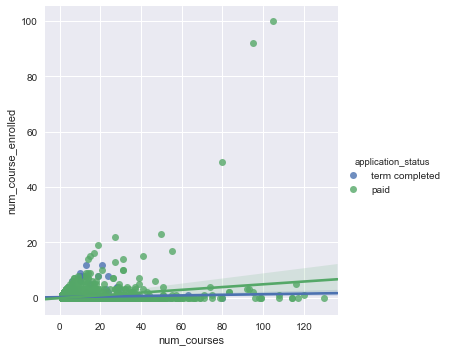

In [18]:
sns.lmplot(x="num_courses", y="num_course_enrolled", data=df, hue='application_status')

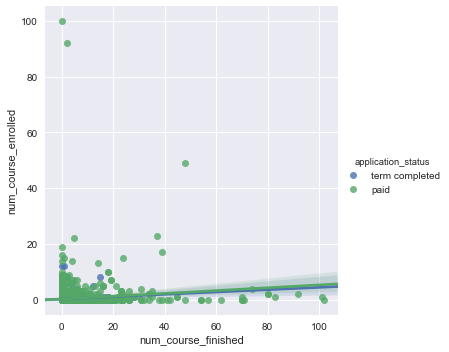

In [19]:
sns.lmplot(x="num_course_finished", y="num_course_enrolled", data=df, hue='application_status')

## Let's do a clustering on user_age, apply_to_submit, apply_before_start, cohort_open_to_close, submit_to_notify

In [71]:
cols = ['user_age','apply_to_submit','apply_before_start','cohort_open_to_notify','submit_to_notify','application_status']
df_clust_1 = df[cols]
#df_clust_1['app_status'] = df_clust_1.assign(df_clust_1['application_status'].apply(lambda x: 1 if x == 'term completed' else 0))
app_status = df_clust_1['application_status'].map({'paid':0,'term completed':1})
df_clust_1 = df_clust_1.assign(app_status = app_status)
df_clust_1.head()

,user_age,apply_to_submit,apply_before_start,cohort_open_to_notify,submit_to_notify,application_status,app_status
0,243,1.0,58,88,29.0,term completed,1
1,130,28.0,10,70,32.0,paid,0
2,198,1.0,68,88,19.0,term completed,1
3,202,9.0,42,64,13.0,paid,0
4,244,0.0,0,64,64.0,paid,0


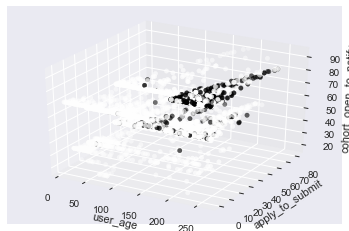

In [21]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_clust_1['user_age'],df_clust_1['apply_to_submit'],df_clust_1['cohort_open_to_notify']
           ,c=df_clust_1['app_status'],marker='o')
ax.set_xlabel('user_age')
ax.set_ylabel('apply_to_submit')
ax.set_zlabel('cohort_open_to_notify')
plt.show()

In [26]:
df_clust_1.groupby(['app_status'])['app_status'].count()

app_status
0    3733
1     648
Name: app_status, dtype: int64

In [72]:
d_1 = df_clust_1.query('app_status==1').reset_index()
d_2 = df_clust_1.query('app_status==0').reset_index()
n = d_1.shape[0]
d_0 = d_2.iloc[random.sample(range(d_2.shape[0]),n),:]
d = pd.concat([d_0,d_1],axis=0)

In [58]:
cols = ['user_age','apply_to_submit','cohort_open_to_notify']
df_clust_1 = df_clust_1[cols]
df_clust_1.shape

(4381, 3)

In [73]:
cols = ['user_age','apply_to_submit','apply_before_start','cohort_open_to_notify','submit_to_notify']
d = d[cols]
d.shape

(1296, 5)

In [74]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import pylab as pl

# use elbow curve to select how many clusters should be considered
from scipy.spatial.distance import cdist, pdist
K = range(1,20)
KM = [KMeans(n_clusters=k, n_jobs=18).fit(d) for k in K]
centroids = [k.cluster_centers_ for k in KM]

D_k = [cdist(d, cent, 'euclidean') for cent in centroids]
cIdx = [np.argmin(D,axis=1) for D in D_k]
dist = [np.min(D,axis=1) for D in D_k]
avgWithinSS = [sum(di)/d.shape[0] for di in dist]

wcss = [sum(di**2) for di in dist]
tss = sum(pdist(d**2)/d.shape[0])
bss = tss-wcss

kIdx = 20-1-1

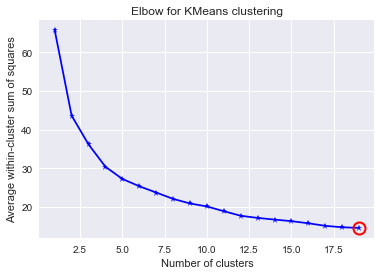

In [75]:
# elbow curve
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(K, avgWithinSS, 'b*-')
ax.plot(K[kIdx], avgWithinSS[kIdx], marker='o', markersize=12, markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('Average within-cluster sum of squares')
plt.title('Elbow for KMeans clustering')

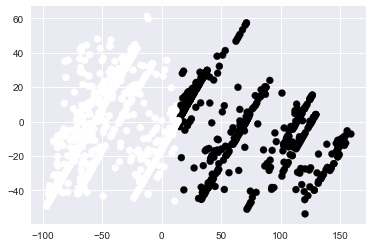

In [76]:
# plot 4 clusters using PCA
pca = PCA(n_components=2).fit(d)
pca_2d = pca.transform(d)
kmeans = KMeans(n_clusters=2, random_state=111).fit(d)
pl.figure('K-means with 2 clusters')
pl.scatter(pca_2d[:, 0], pca_2d[:, 1], c=kmeans.labels_)
pl.show()
# patterns shows in data

### elbow curve looks like clustering might not be a good way to go!

## Let's do another clustering on user_age, apply_to_submit, apply_before_start, cohort_open_to_close, submit_to_notify, num_courses, num_course_finished

In [77]:
cols = ['user_age','apply_to_submit','apply_before_start','cohort_open_to_notify','submit_to_notify'
        ,'num_courses','num_course_finished','application_status']
df_clust_2 = df[cols]
#df_clust_1['app_status'] = df_clust_1.assign(df_clust_1['application_status'].apply(lambda x: 1 if x == 'term completed' else 0))
app_status = df_clust_2['application_status'].map({'paid':0,'term completed':1})
df_clust_2 = df_clust_2.assign(app_status = app_status)
df_clust_2.head()

,user_age,apply_to_submit,apply_before_start,cohort_open_to_notify,submit_to_notify,num_courses,num_course_finished,application_status,app_status
0,243,1.0,58,88,29.0,3,0,term completed,1
1,130,28.0,10,70,32.0,2,0,paid,0
2,198,1.0,68,88,19.0,5,1,term completed,1
3,202,9.0,42,64,13.0,11,0,paid,0
4,244,0.0,0,64,64.0,22,4,paid,0


In [78]:
d_1 = df_clust_2.query('app_status==1').reset_index()
d_2 = df_clust_2.query('app_status==0').reset_index()
n = d_1.shape[0]
d_0 = d_2.iloc[random.sample(range(d_2.shape[0]),n),:]
d = pd.concat([d_0,d_1],axis=0)

In [79]:
cols = ['user_age','apply_to_submit','apply_before_start','cohort_open_to_notify','submit_to_notify']
d = d[cols]
d.shape

(1296, 5)

In [80]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import pylab as pl

# use elbow curve to select how many clusters should be considered
from scipy.spatial.distance import cdist, pdist
K = range(1,20)
KM = [KMeans(n_clusters=k, n_jobs=18).fit(d) for k in K]
centroids = [k.cluster_centers_ for k in KM]

D_k = [cdist(d, cent, 'euclidean') for cent in centroids]
cIdx = [np.argmin(D,axis=1) for D in D_k]
dist = [np.min(D,axis=1) for D in D_k]
avgWithinSS = [sum(di)/d.shape[0] for di in dist]

wcss = [sum(di**2) for di in dist]
tss = sum(pdist(d**2)/d.shape[0])
bss = tss-wcss

kIdx = 20-1-1

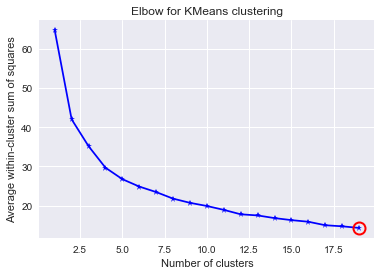

In [81]:
# elbow curve
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(K, avgWithinSS, 'b*-')
ax.plot(K[kIdx], avgWithinSS[kIdx], marker='o', markersize=12, markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('Average within-cluster sum of squares')
plt.title('Elbow for KMeans clustering')

### elbow curve still shows clustering not be a good way to go!

### only look at user_age + apply_to_submit

In [82]:
cols = ['user_age','apply_to_submit'
        ,'application_status']
df_clust_3 = df[cols]
app_status = df_clust_3['application_status'].map({'paid':0,'term completed':1})
df_clust_3 = df_clust_3.assign(app_status = app_status)
df_clust_3.head()

,user_age,apply_to_submit,application_status,app_status
0,243,1.0,term completed,1
1,130,28.0,paid,0
2,198,1.0,term completed,1
3,202,9.0,paid,0
4,244,0.0,paid,0


In [83]:
d_1 = df_clust_3.query('app_status==1').reset_index()
d_2 = df_clust_3.query('app_status==0').reset_index()
n = d_1.shape[0]
d_0 = d_2.iloc[random.sample(range(d_2.shape[0]),n),:]
d = pd.concat([d_0,d_1],axis=0)

In [84]:
cols = ['user_age','apply_to_submit']
d = d[cols]
d.shape

(1296, 2)

In [85]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import pylab as pl

# use elbow curve to select how many clusters should be considered
from scipy.spatial.distance import cdist, pdist
K = range(1,20)
KM = [KMeans(n_clusters=k, n_jobs=18).fit(d) for k in K]
centroids = [k.cluster_centers_ for k in KM]

D_k = [cdist(d, cent, 'euclidean') for cent in centroids]
cIdx = [np.argmin(D,axis=1) for D in D_k]
dist = [np.min(D,axis=1) for D in D_k]
avgWithinSS = [sum(di)/d.shape[0] for di in dist]

wcss = [sum(di**2) for di in dist]
tss = sum(pdist(d**2)/d.shape[0])
bss = tss-wcss

kIdx = 20-1-1

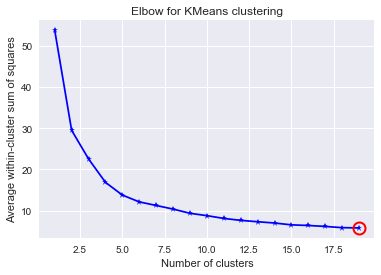

In [86]:
# elbow curve
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(K, avgWithinSS, 'b*-')
ax.plot(K[kIdx], avgWithinSS[kIdx], marker='o', markersize=12, markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('Average within-cluster sum of squares')
plt.title('Elbow for KMeans clustering')

### look at user_age + apply_to_submit + apply_before_start

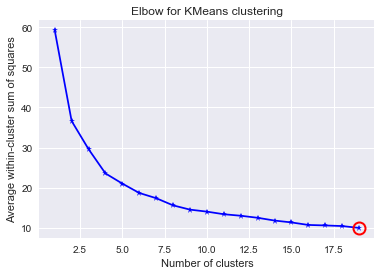

In [87]:
cols = ['user_age','apply_to_submit','apply_before_start','application_status']
df_clust_3 = df[cols]
app_status = df_clust_3['application_status'].map({'paid':0,'term completed':1})
df_clust_3 = df_clust_3.assign(app_status = app_status)


d_1 = df_clust_3.query('app_status==1').reset_index()
d_2 = df_clust_3.query('app_status==0').reset_index()
n = d_1.shape[0]
d_0 = d_2.iloc[random.sample(range(d_2.shape[0]),n),:]
d = pd.concat([d_0,d_1],axis=0)


cols = ['user_age','apply_to_submit','apply_before_start']
d = d[cols]


# use elbow curve to select how many clusters should be considered
K = range(1,20)
KM = [KMeans(n_clusters=k, n_jobs=18).fit(d) for k in K]
centroids = [k.cluster_centers_ for k in KM]

D_k = [cdist(d, cent, 'euclidean') for cent in centroids]
cIdx = [np.argmin(D,axis=1) for D in D_k]
dist = [np.min(D,axis=1) for D in D_k]
avgWithinSS = [sum(di)/d.shape[0] for di in dist]

wcss = [sum(di**2) for di in dist]
tss = sum(pdist(d**2)/d.shape[0])
bss = tss-wcss

kIdx = 20-1-1


# elbow curve
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(K, avgWithinSS, 'b*-')
ax.plot(K[kIdx], avgWithinSS[kIdx], marker='o', markersize=12, markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('Average within-cluster sum of squares')
plt.title('Elbow for KMeans clustering')